# Case study: The great inflation in 1980s

In this guide, we will explore the different methods and techniques that can be used to analyze the New York Times news archive and study the Great Inflation of the 1980s using OpenAI API. We will cover everything from data preparation and preprocessing to machine learning models and visualization techniques.

- Dataset: 
    * The dataset used in this project is sourced from the New York Times news archive and is available through the New York Times API. (open source and free)
    * The quality of the data may vary, and some information may be incomplete or missing due to the fact that it is based on digitized versions of printed newspapers
- Methodology:
    * pre-processing and pre-analysis
        * Filtering: Filter dates, news sector, and news desk; Data cleaning.
        * Pre-analysis: Using ChatGPT API to analyze a sample of data and generate summaries that can help to identify the most relevant topics and to guide the subsequent analysis.
    * Main process:
        * Utilize OpenAI API to embed the abstract of each article
        * Perform semantic analysis on various economics topics
        * Calculate sentiment values for each topic on each day
        * Create a trend index using pre-defined time decay functions
        * Compare the topic trend gained from news with related economic indices and explore whether there is any link between the two


# 1. Prepare data: filter related text and clean text

In [25]:
import os
import pandas as pd
import datetime as dt
import numpy as np

import tiktoken
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

In [20]:
# 1.1 load all csv files in the folder by year

# get curret working directory
dir = os.getcwd()
folder_path = os.path.join(dir, 'INPUT/ny_times_news')

# get all files in the directory
files = os.listdir(folder_path)
# select csv files include 1981
files = [file for file in files if '1981' in file]

# read all csv files, select column "lead_paragraph", print_page and news_desk, section_name
# and save to a list
df_list = []
for file in files:
    file_path = os.path.join(folder_path, file)
    # read csv file,only select column "lead_paragraph", print_page and news_desk,section_name,pub_date
    df = pd.read_csv(file_path, usecols=['pub_date', 'print_page', 'news_desk', 'section_name',"print_section",'lead_paragraph','abstract'])
    df_list.append(df)

#concatenate all dataframes
data = pd.concat(df_list, axis=0, ignore_index=True)

#convert pub_date''1981-10-30T05:00:00+0000' to datetime YYYY-MM-DD
data['pub_date'] = pd.to_datetime(data['pub_date']).dt.date

In [24]:
# 1.2 data filtering

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#slect rows where print_page = 1, 'print_section' == 'D' & 'news_desk' == 'Financial Desk'
df = data[(data['print_page'] == 1) & (data['print_section'] == 'D')&(data['news_desk'] == 'Financial Desk')]

In [ ]:
# 1.3 data cleaning

#remove special characters in lead_paragraph
df["lead_paragraph"] = df["lead_paragraph"].str.replace('[^\w\s]','')
df["abstract"] = df["abstract"].str.replace('[^\w\s]','')
df = df.dropna(subset=['abstract'])
# convert abstract to text
df['abstract'] = df['abstract'].astype(str)
#lowercase
df['abstract'] = df['abstract'].str.lower()
#clean space in the beginning and end of the string
df['abstract'] = df['abstract'].str.strip()

df = df.reset_index(drop=True)

<AxesSubplot:>

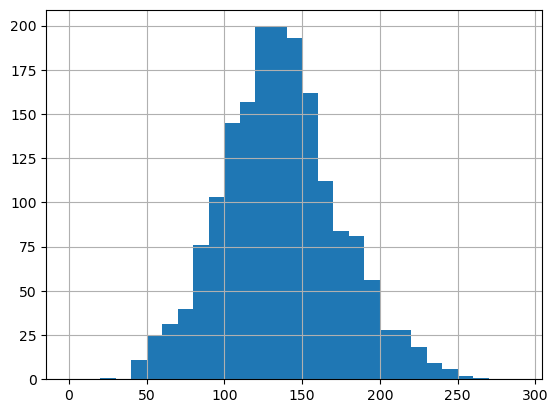

In [26]:
# 1.4 text tokenization

df["n_tokens"] = df["abstract"].apply(lambda x: len(tokenizer.encode(x)))
#plot histogram of n_tokens step = 10
df['n_tokens'].hist(bins=range(0, 300, 10))

In [27]:
# 1.5 one more data filtering by n_tokens
#select rows where n_tokens >10 to remove meaningless rows
df = df[df['n_tokens'] >10]

# 2. Pre-analyze: text topic using chatGPT

In [ ]:
import openai

# topic extraction
def pattern_anlysis(prompt,text):

    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are a helpful assistant that summarize and analyze text."},
            {"role": "user", "content": prompt + text},
        ]
    )

    return response

In [ ]:
#select rows where n_tokens < 13
df_title = df[df['n_tokens'] < 50]
#combine all leading_paragraph to a text
text_title = df_title['abstract'].str.cat(sep='-')

prompt1 = """Please analyze the following news abstract from New York Times and list categories for the different topics in these news by importance. The abstract is separated by dash (-) and is as follows:
"""
response1 = pattern_anlysis(prompt1, text_title)
print(response1["usage"]["total_tokens"])
print(response1['choices'][0]['message']['content'])

### 1983 
Tokens: 1058

Categories for the different topics in this news by importance are:

1. Economy:
- New orders to factories rose in January
- Recovery of the economy
- Congress altering budget proposals to reduce deficits
- Confirmation of Paul A. Volcker to direct the fed
- Capital outlays for new plants are lagging

2. International economic issues:
- Britain may delay a major cut in its north sea oil price
- The global debt crisis will persist unless industrial nations take steps to stimulate their economies
- Brazil says it needs more aid despite recent huge borrowings from international lending agencies and private banks
- Worldwide economic recovery and banking stability at stake if a significant portion of 700 billion in debt amassed by developing nations should be repudiated

3. Corporate profits:
- Corporate profits have rebounded sharply in some industries

4. Banking:
- Introduction of high-interest checking accounts getting a cool reception
- Plans to revamp regulation of the nation's financial system appear unlikely in 1984
- United States trade negotiators seeking fairness for exports of services in any new round of multilateral talks

5. Taxes:
- Long fight expected over legislation to withhold taxes on interest and dividends
- Some business leaders favor big tax increases if this reduces federal deficit

Overall, the most important category is the economy, followed by international economic issues, corporate profits, banking, and taxes.


### 1981
Tokens: 1050 
1. Economic Policy: President-elect Reagan's outside group of prominent Republicans to provide economic policy advice
2. Gasoline Prices: Near record gasoline supplies promising to slow price rises at the pump
3. Television and Video Equipment Sales: Sales expected to exceed previous forecasts for television and other video equipment
4. Monetarist Policy: Reagan administration's strict monetarist policy is causing serious problems for other nations
5. Tax Plans: Big business remains solidly behind the president's tax plans, while operators of small business are cooler
6. West German Recession: West German recession raises doubts about Bonn's future as the economic engine of Europe
7. Oil Prices: Egypt reduced oil prices retroactive to April 1
8. Retailers: Retailers face concerns over undercutting traditional January bargain shopping
9. Trade Deficit with Japan: The US trade deficit with Japan may exceed $15 billion this year, threatening to lead to new trade frictions between the two countries
10. Thrift Institutions: Falling interest rates will not bring fast near-term relief to thrift institutions, as they must work off high-rated deposits
11. Tax-exempt Industrial Development Bond Issues: The flood of tax-exempt industrial development bond issues worries securities firms
12. Holiday Sales: Retailers planning more aggressive advertising and price-cutting for a difficult holiday season
13. US Recession: The US is in a slight recession, acknowledged by President Reagan for the first time
14. Financing Plans: Treasury to give details of its financing plans for the rest of 1981, heavy government borrowing being a key ingredient in the behavior of the credit markets.
 

# 3. Text embedding and search query embedding

* Models:
    * OpenAI embedding model: 'text-embedding-ada-002' is used to embed all news abstracts and topics
    * OpenAI tockenizer: cl100k_base tokenizer, which is designed to work with the ada-002 model

* Predefined topics:
    * Opposite attitude/direction of topics is defined with a list of sentences to understand sentiment
    * Single word embedding for each topic is created to identify the most salient news

## 3.1 Text embedding

In [2]:
import plotly.express as px
import openai
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

In [ ]:
# remove newlines for better performance of embedding model

def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')

    return serie

df_embedding = df.copy()
df_embedding['text'] = remove_newlines(df.abstract)

#reset index
df_embedding = df_embedding.reset_index(drop=True)

In [ ]:
dic = {}

for i in df_embedding.index:

    x = df_embedding.text.values[i]
    embedding = openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding']
    dic[i] = embedding
    print(i)

#add embeddings to dataframe
df_embedding['embeddings'] = dic.values()

#save csv
df_embedding.to_csv(os.path.join(dir,'OUTPUT/ny_times_news_1981.csv'), index=False)

## 3.2 Topic Embedding

In [4]:
#sentences dic

topic_dic = {}

topic_dic['inflation'] = [
"inflation will rise",
"inflation will fall"
]

topic_dic['price'] = [
"price will increase",
"price will decrease"]

topic_dic['oil price'] = [
"oil price will increase",
"oil price will decrease"]

topic_dic['unemployment rate'] = [
"unemployment rate will rise",
"unemployment rate will fall"]

topic_dic['interest rate'] = [
"interest rate will rise",
"interest rate will fall"]

topic_dic['economic growth'] = [
"economic growth will speed up",
"economic growth will slow down"]

topic_dic['money supply'] = [
"money supply will increase",
"money supply will decrease"]

In [5]:
dic_embeddings_topic = {}
for topic in topic_dic.keys():
    li = []
    for question in topic_dic[topic]:
        embedding = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']
        li.append(embedding)
    dic_embeddings_topic[topic] = li 

In [6]:
# single topic dic

single_topic_list  = ["inflation",
                      "price",
                      "oil price",
                      "unemployment rate",
                      "interest rate",
                      "economic growth",
                      "money supply",
                      "recession"]

dic_embeddings_single = {}

for topic in single_topic_list:
    dic_embeddings_single[topic] = openai.Embedding.create(input=topic, engine='text-embedding-ada-002')['data'][0]['embedding']


# 4. Main Functions

In this part, we defined several core functions to calculate and adjust similarity value and trend index, aggreate values and apply time decay.

## 4.1 Adjust value

In [42]:
# adjust similarity value
def adjust_value(value,power = 8,min_threshold = 0.2):
    if value < min_threshold:
        value = 0
    value = value**power
    
    return value

## 4.2 Decay Function

In [43]:
import numpy as np

def half_life(x, A, B):
    return A * 0.5**(x/B)

# Example usage
t = np.arange(0, 360, 1)
weight = half_life(t, 1, 50)

# Plot the function using plotly
fig = px.line(x=t, y=weight)
#set title and title size
fig.update_layout(title='Decay Function', title_x=0.5, title_font_size=20,
                  #set x and y axis title
                  xaxis_title="day", yaxis_title="weight",
                  #set x and y axis title size
                  xaxis_title_font_size=20, yaxis_title_font_size=20,
                  #set fig size
                  width=500, height=500
            )
fig.show()

## 4.3 Cumsum with decayed weights

In [44]:
def cumulate_sum_with_decay(df, topic, 
                            decay_days,A,B):
    
    # Example usage
    x = np.arange(0, decay_days, 1)
    y = half_life(x, A, B)

    decay_weights = y

    cumulated_values = []
    for i in range(len(df)):
        end_index = i+1
        start_index = max(0, end_index - decay_days)
        window_values = df[topic].iloc[start_index:end_index].to_numpy()
        window_weights = decay_weights[:len(window_values)][::-1]
        #multiply the values in the list with the weights
        weighted_values = window_values * window_weights
        cumulated_value = weighted_values.sum()
        cumulated_values.append(cumulated_value)

    df[topic+"_trend"] = cumulated_values

    return df


# 5. Main body

Now let's play with the data!


In [45]:
#load df
def load_embedding_data(year):
    file_name = 'ny_times_news_' + str(year) + '.csv'
    df_embedding = pd.read_csv(os.path.join(dir,'OUTPUT/' + file_name))
    df_embedding['embeddings'] = df_embedding['embeddings'].apply(eval).apply(np.array)

    return df_embedding

In [51]:
# trend generation

def generate_trend(topic,df_embedding,decay_days,A,B):

    df_sim = df_embedding[["pub_date","embeddings"]]

    for i in range(len(topic_dic[topic])):
        sub_topic = topic_dic[topic][i]
        embedding = dic_embeddings_topic[topic][i]
        # Get the distances from the embeddings
        df_sim[sub_topic] = distances_from_embeddings(embedding, df_sim['embeddings'].values, distance_metric='cosine')
        # get similarity from distance
        df_sim[sub_topic] = 1 - df_sim[sub_topic]
        
    ########   adjust values (before or after cal difference?)

    df_sim = df_sim.drop(columns=['embeddings'])
    #adjust values 1.remove values below threshold(unrelated to the topic) 2. raise to power
    df_sim.set_index('pub_date', inplace=True)
    df_sim = df_sim.applymap(lambda x: adjust_value(x))

    #get the difference between the two questions
    df_sim[topic] = df_sim[topic_dic[topic][0]] - df_sim[topic_dic[topic][1]]

    #sum by date /mean by date(considering counts)
    df_sim.reset_index(inplace=True)
    df_sim = df_sim.groupby('pub_date').mean()

    # create value with time decay
    df_trend = cumulate_sum_with_decay(df_sim, topic, decay_days,A,B)

    return df_trend


def generate_trend_ratio(topic,df_embedding,decay_days,A,B):

    df_sim = df_embedding[["pub_date","embeddings"]]

    for i in range(len(topic_dic[topic])):
        sub_topic = topic_dic[topic][i]
        embedding = dic_embeddings_topic[topic][i]
        # Get the distances from the embeddings
        df_sim[sub_topic] = distances_from_embeddings(embedding, df_sim['embeddings'].values, distance_metric='cosine')
        # get similarity from distance
        df_sim[sub_topic] = 1 - df_sim[sub_topic]
        
    ########   adjust values (before or after cal difference?)

    df_sim = df_sim.drop(columns=['embeddings'])
    #adjust values 1.remove values below threshold(unrelated to the topic) 2. raise to power
    df_sim.set_index('pub_date', inplace=True)
    df_sim = df_sim.applymap(lambda x: adjust_value(x))

    #drop the values below threshold
    #df_sim = df_sim[df_sim[topic_dic[topic][0]] > 0]
    #df_sim = df_sim[df_sim[topic_dic[topic][1]] > 0]

    #get the value by compare the values between the two questions, then assign 1 or -1
    df_sim[topic] = df_sim[topic_dic[topic][0]] - df_sim[topic_dic[topic][1]]
    df_sim[topic] = df_sim[topic].apply(lambda x : 1 if x > 0 else -1)

    #sum by date
    df_sim.reset_index(inplace=True)
    #get the ratio of 1 in the day
    df_sim = df_sim.groupby('pub_date').mean() # n_rise -n_fall / total_n

    # option 1 log the ratio
    #df_sim[topic] = df_sim[topic].apply(lambda x : np.log(x))

    # option 2 if the value is 0, set it to 0.5
    #df_sim[topic] = df_sim[topic].apply(lambda x : 0.7 if x == 1 else x)
    #df_sim[topic] = df_sim[topic].apply(lambda x : -0.7 if x == -1 else x)

    # create value with time decay
    df_trend = cumulate_sum_with_decay(df_sim, topic, decay_days,A,B)

    return df_trend



## 5.1 Load historic data of indexes

In [16]:
import pandas as pd
import os
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [28]:
#load CPI data
df_cpi = pd.read_csv(os.path.join(dir,'INPUT/CPI_monthly.csv'))

#selct year from 1979 to 1983
df_cpi = df_cpi[df_cpi['Year'] >= 1979]
df_cpi = df_cpi[df_cpi['Year'] <= 1983]
#rename column
df_cpi.rename(columns={'Year':'year','Period':'month','Label':'date','12-Month % Change':'CPI_change'}, inplace=True)
#convert label to datetime
df_cpi['date'] = pd.to_datetime(df_cpi['date'])
#resample to daily at end of month
df_cpi_daily = df_cpi.set_index('date').resample('D').ffill()

#only keep the value for start of month
df_cpi_daily = df_cpi_daily[df_cpi_daily.index.day == 1]

#resample to daily and interplate the missing values
df_cpi_daily = df_cpi_daily.resample('D').interpolate()
df_cpi_daily.head()

,year,month,CPI_change
date,,,
1979-01-01,1979.0,M01,9.300000
1979-01-02,1979.0,NaN,9.319355
1979-01-03,1979.0,NaN,9.338710
1979-01-04,1979.0,NaN,9.358065
1979-01-05,1979.0,NaN,9.377419


In [31]:
#load CPI_oil data
df_oil_price = pd.read_csv(os.path.join(dir,'INPUT/oil_price_monthly.csv'))
#convert label to datetime
df_oil_price['date'] = pd.to_datetime(df_oil_price['date'])
#resample to daily and interplate the missing values
df_oil_price_daily = df_oil_price.set_index('date').resample('D').interpolate()
df_oil_price_daily.head()

,oil_price
date,
1974-01-01,6.950000
1974-01-02,6.947419
1974-01-03,6.944839
1974-01-04,6.942258
1974-01-05,6.939677


In [32]:
#load CPI_oil data
df_cpi_oil = pd.read_csv(os.path.join(dir,'INPUT/CPI_oil_monthly.csv'))
#convert label to datetime
df_cpi_oil['date'] = pd.to_datetime(df_cpi_oil['date'])
#resample to daily and interplate the missing values
df_cpi_oil_daily = df_cpi_oil.set_index('date').resample('D').interpolate()
df_cpi_oil_daily.head()

,CPI_oil
date,
1979-01-01,56.000000
1979-01-02,56.012903
1979-01-03,56.025806
1979-01-04,56.038710
1979-01-05,56.051613


In [33]:
# load yield data
df_yield = pd.read_csv(os.path.join(dir,'INPUT/2y_yield_daily.csv'))
#drop na
df_yield = df_yield.dropna()
#convert to datetime from string d/m/y
df_yield['date'] = pd.to_datetime(df_yield['date'])
#convert yield to numeric
df_yield['yield'] = pd.to_numeric(df_yield['yield'])
#resample to daily at end of month and ffill "forward"
df_yield_daily = df_yield.set_index('date').resample('D').ffill()
df_yield_daily.head()

,yield
date,
1979-01-02,10.00
1979-01-03,9.98
1979-01-04,9.88
1979-01-05,9.87
1979-01-06,9.87


In [55]:
#plot yield and cpi use plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_cpi_daily.index, y=df_cpi_daily['CPI_change'],
                    mode='lines',
                    name='CPI'))
fig.add_trace(go.Scatter(x=df_yield_daily.index, y=df_yield_daily['yield'],
                    mode='lines',
                    name='yield'))

#adjust size
fig.update_layout(
    autosize=False,
    width=1000,
    height=500
)

fig.show()

## 5.2 Load text embeddings

In [30]:
df_embedding_1979 = load_embedding_data(1979)
df_embedding_1980 = load_embedding_data(1980)
df_embedding_1981 = load_embedding_data(1981)
df_embedding_1982 = load_embedding_data(1982)
df_embedding_1983 = load_embedding_data(1983)


In [35]:
print(df_embedding_1979.shape[0])
print(df_embedding_1980.shape[0])
print(df_embedding_1981.shape[0])
print(df_embedding_1982.shape[0])
print(df_embedding_1983.shape[0])

1827
1671
1769
1766
1756


In [36]:
#concat 3 years
df_embedding = pd.concat([df_embedding_1979,df_embedding_1980,df_embedding_1981,df_embedding_1982,df_embedding_1983], ignore_index=True)
#convert pub_date to datetime
df_embedding['pub_date'] = pd.to_datetime(df_embedding['pub_date'])

In [60]:
df_embedding.head()

,abstract,lead_paragraph,print_section,print_page,pub_date,news_desk,section_name,n_tokens,text,embeddings
0,h kramer comment on center designed by renzo p...,HILTON KRAMER,D,1.0,1979-07-01,None,Archives,19,h kramer comment on center designed by renzo p...,"[0.0017989255720749497, 0.011241082102060318, ..."
1,w kerr comment on actors who have excelled in ...,WALTER KERR,D,1.0,1979-07-01,None,Archives,116,w kerr comment on actors who have excelled in ...,"[-0.004528515972197056, 0.014059899374842644, ..."
2,economic forum of conference board group of ec...,A consensus has developed among private econom...,D,1.0,1979-07-02,None,Archives,92,economic forum of conference board group of ec...,"[-0.04126919060945511, -0.027610043063759804, ..."
3,comment on costume house small costume busines...,TORONTO June 29 For many years Warren Hughes ...,D,1.0,1979-07-02,None,Archives,68,comment on costume house small costume busines...,"[-0.01984664797782898, -0.0233698021620512, -0..."
4,john e nash director of s g warburg co commen...,The dollar has had rough going in foreign mone...,D,1.0,1979-07-02,None,Archives,24,john e nash director of s g warburg co comment...,"[-0.02872130461037159, -0.011729959398508072, ..."


## 5.3 Plot trend: sentiment search using sentence pairs

In [39]:
#ignore error
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

### similarity distribution analysis

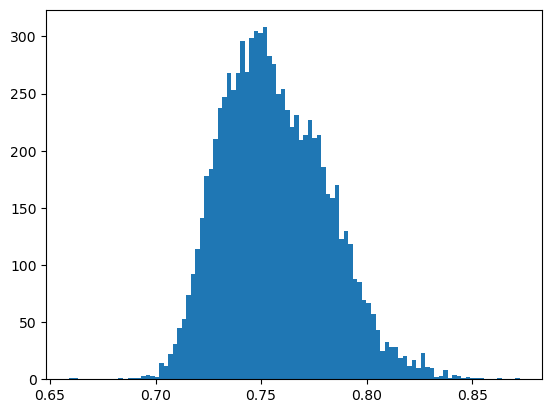

217
344
320
385


In [49]:
#"inflation" similarity distribution

df_inflation = df_embedding.copy()
df_inflation["distance"] = distances_from_embeddings(dic_embeddings_single["inflation"], df_inflation["embeddings"], distance_metric='cosine')
df_inflation["similarity"] = 1 - df_inflation["distance"]

#plot similarity distribution
plt.hist(df_inflation["similarity"], bins=100)
plt.show()

#select the text with similarity > 0.78
df_inflation_select = df_inflation[df_inflation["similarity"] > 0.78]

#view the selected text
df_inflation_1979 = df_inflation_select[df_inflation_select["pub_date"].dt.year == 1979]
df_inflation_1980 = df_inflation_select[df_inflation_select["pub_date"].dt.year == 1980]
df_inflation_1981 = df_inflation_select[df_inflation_select["pub_date"].dt.year == 1981]
df_inflation_1982 = df_inflation_select[df_inflation_select["pub_date"].dt.year == 1982]
df_inflation_1983 = df_inflation_select[df_inflation_select["pub_date"].dt.year == 1983]

print(df_inflation_1979.shape[0])
print(df_inflation_1980.shape[0])
print(df_inflation_1981.shape[0])
print(df_inflation_1982.shape[0])

In [ ]:
#interest rate similarity distribution

df_int = df_embedding.copy()
df_int["distance"] = distances_from_embeddings(dic_embeddings_single["interest rate"], df_int["embeddings"], distance_metric='cosine')
df_int["similarity"] = 1 - df_int["distance"]

#plot similarity distribution
plt.hist(df_int["similarity"], bins=100)
plt.show()

#select the text with similarity > 0.78
df_int_select = df_int[df_int["similarity"] > 0.78]

#select year of 1983 in df_inflation
df_int_1979 = df_int_select[df_int_select["pub_date"].dt.year == 1979]
df_int_1980 = df_int_select[df_int_select["pub_date"].dt.year == 1980]
df_int_1981 = df_int_select[df_int_select["pub_date"].dt.year == 1981]
df_int_1982 = df_int_select[df_int_select["pub_date"].dt.year == 1982]
df_int_1983 = df_int_select[df_int_select["pub_date"].dt.year == 1983]

#sort values by similarity
print(df_int_1979.shape[0])
print(df_int_1980.shape[0])
print(df_int_1981.shape[0])
print(df_int_1982.shape[0])
print(df_int_1983.shape[0])

In [ ]:
# test: how to differentiate topics which are similar in embeddings

# sections
sections = ["oil price", "inflation", "interest rate", "monetary policy", "economic growth", "unemployment"]

dic_embeddings_sections = {}

for section in sections:
    df_inflation[section] = openai.Embedding.create(input=section, engine='text-embedding-ada-002')['data'][0]['embedding']

# Get the distances from the embeddings
df_sim = df_embedding.copy()
for section in dic_embeddings_sections.keys():
    embedding = dic_embeddings_sections[section]
    # get distance from embeddings
    df_sim[section] = distances_from_embeddings(embedding, df_sim['embeddings'].values, distance_metric='cosine')
    # get similarity from distance
    df_sim[section] = 1 - df_sim[section]

# find the highest similarity and asign it to the row
df_sim['section'] = df_sim[sections].idxmax(axis=1)
#select section = business
df_inflation = df_sim[df_sim.section == 'inflation']

### Inflation

In [52]:
# inflation by sub topics
df_inflation_select = df_inflation[df_inflation["similarity"] > 0.75]
df_trend = generate_trend("inflation",df_inflation_select,360,1,50)
#left join cpi data on index
df_trend = df_trend.join(df_yield_daily)
# scale trend value to 0-100
df_trend['inflation_trend'] = df_trend['inflation_trend'] - df_trend['inflation_trend'].min()
df_trend['inflation_trend'] = df_trend['inflation_trend'] / df_trend['inflation_trend'].max()*100
#plot inflation on left axis and CPI_change on right axix
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['inflation_trend'], name="inflation_trend"),secondary_y=False)
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['yield'], name="Market Yield on 2-Year U.S. Treasury Securities"),secondary_y=True)
fig.update_layout(
    title="Topic Trend: Inflation",
    autosize=False,
    width=1100,
    height=500,
    )
fig.show()


### Interest Rate

In [ ]:
# interest rate by sub topics

#select the text with similarity > 0.75
df_int_select = df_int[df_int["similarity"] > 0.79]

df_trend = generate_trend("interest rate",df_int_select,360,1,50)
#left join cpi data on index
df_trend = df_trend.join(df_yield_daily)
#plot inflation on left axis and CPI_change on right axis

# scale trend value to 0-100
df_trend['interest rate_trend'] = df_trend['interest rate_trend'] - df_trend['interest rate_trend'].min()
df_trend['interest rate_trend'] = df_trend['interest rate_trend']/df_trend['interest rate_trend'].max()*100

df_trend_int = df_trend.copy()

#df_trend_index = df_trend_index[df_trend_index.index.year == 1983]
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['interest rate_trend'], name="interest rate topic trend"),secondary_y=False)
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['yield'], name="Market Yield on 2-Year U.S. Treasury Securities"),secondary_y=True)
fig.update_layout(
    title="Topic Trend: Interest Rate",
    autosize=False,
    width=1200,
    height=500,
    )
fig.show()

### Oil Price

In [ ]:
# oil price
# interest rate by sub topics
#select the text with similarity > 0.75


df_oil = df_embedding.copy()
df_oil["distance"] = distances_from_embeddings(dic_embeddings_single["oil price"], df_oil["embeddings"], distance_metric='cosine')
df_oil["similarity"] = 1 - df_oil["distance"]
#select the text with similarity > 0.75
df_oil_select = df_oil[df_oil["similarity"] > 0.78]

df_trend = generate_trend_ratio("oil price",df_oil_select,360,1,50)
#left join cpi data on index
df_trend = df_trend.join(df_oil_price_daily)
df_trend = df_trend.join(df_cpi_oil_daily)
df_trend = df_trend.join(df_yield_daily)
#plot inflation on left axis and CPI_change on right axis
#scale oil price and CPI and trend and yield to 0-100 and positive
df_trend['oil_price'] = df_trend['oil_price'] - df_trend['oil_price'].min()
df_trend['CPI_oil'] = df_trend['CPI_oil'] - df_trend['CPI_oil'].min()
df_trend['oil price_trend'] = df_trend['oil price_trend'] - df_trend['oil price_trend'].min()
df_trend['yield'] = df_trend['yield'] - df_trend['yield'].min()

df_trend['oil_price'] = df_trend['oil_price']/df_trend['oil_price'].max()*100
df_trend['CPI_oil'] = df_trend['CPI_oil']/df_trend['CPI_oil'].max()*100
df_trend['oil price_trend'] = df_trend['oil price_trend']/df_trend['oil price_trend'].max()*100
df_trend['yield'] = df_trend['yield']/df_trend['yield'].max()*100

df_trend_oil = df_trend.copy()

# select year of 1981
#df_trend_index = df_trend_index[df_trend_index.index.year == 1983]
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['oil price_trend'], name="oil price topic trend"),secondary_y=False)
#fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['oil_price'], name="U.S. Crude Oil First Purchase Price Dollars per Barrel"),secondary_y=True)
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['CPI_oil'], name="CPI for All Urban Consumers: Gasoline in U.S. City Average"),secondary_y=True)
fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['yield'], name="Market Yield on 2-Year U.S. Treasury Securities"),secondary_y=True)
fig.update_layout(
    title  = "Topic Trend: Oil Price",
    autosize=False,
    width=1200,
    height=500,
    )
fig.show()

In [ ]:
# calculate the correlation among oil_price_trend and CPI_oil and yield
df_cor  = df_trend_oil.copy()
df_cor['oil price_trend'].corr(df_cor['CPI_oil'])
#df_cor['oil price_trend'].corr(df_cor['yield'])

## 5.4 Single topic/sentence searching

In [56]:
def generate_single_trend(topic,df_embedding,join_index_df,decay_days,A,B,power,drop = False):

    df_sim = df_embedding[["pub_date","embeddings"]]

    if topic in dic_embeddings_single.keys():
        embedding = dic_embeddings_single[topic]
    else:
        embedding = openai.Embedding.create(input=topic, engine='text-embedding-ada-002')['data'][0]['embedding']
        dic_embeddings_single[topic] = embedding
        
    # Get the distances from the embeddings
    df_sim[topic] = distances_from_embeddings(embedding, df_sim['embeddings'].values, distance_metric='cosine')
    # get similarity from distance
    df_sim[topic] = 1 - df_sim[topic]
        
    ########   adjust values (before or after cal difference?)

    df_sim = df_sim.drop(columns=['embeddings'])
    #adjust values 1.remove values below threshold(unrelated to the topic) 2. raise to power
    df_sim.set_index('pub_date', inplace=True)
    df_sim = df_sim.applymap(lambda x: adjust_value(x,power,min_threshold = 0.2))

    #sum by date
    df_sim.reset_index(inplace=True)
    df_sim = df_sim.groupby('pub_date').sum()  ### !!!!!! main difference between single and multi topic search

    # create value with time decay
    df_trend = cumulate_sum_with_decay(df_sim, topic, decay_days,A,B)

    df_trend = df_trend.join(join_index_df)

    if drop:
        df_trend = df_trend[decay_days:]

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend[topic+'_trend'], name= topic ),secondary_y=False)
    fig.add_trace(go.Scatter(x=df_trend.index, y=df_trend['CPI_change'], name="CPI change"),secondary_y=True)
    fig.update_layout(
        title="Trend: " + topic,
        autosize=False,
        width=1000,
        height=500,
        )

    return df_trend, fig

In [57]:
# inflation
df_trend,fig = generate_single_trend("people are worried about inflation",df_inflation_select,df_cpi_daily,180,1,30,power=10,drop = True)
fig.show()